# 1. Overview of Chatbot Personality Analysis

This notebook provides an overview of this research product by describing the research questions, the data gathered, and the analysis conducted. Each research question is addressed in a separate notebook as follow:
  
<code>
1_RQ1_user_experience.ipynb 
2_RQ2_personality_simulation.ipynb 
3_RQ3_user_personality.ipynb 
</code>


# 2. Research Questions

#### RQ1: Does the personality demonstrated by a chatbot affect the user’s experience?

- Which chatbot did the participant prefer? (show counts for each chatbot - bar chart, pie chart, ratio etc.)
    - How does this align with the participant's personality? (correlation between extraversion and preference, agreebleness and preference, can use logistic regression or point biserial correlation)
- Is the preferred chatbot experience positively correlated with conversation engagement metrics such as conversation length? (logistic regression)


#### RQ2: Can Personality be simulated by a chatbot?

- Do participants reliably identify differences between chatbot personality?
- Do participants prefer one chatbot over the other because of its personality?

#### RQ3: Can a user’s personality be inferred through their interaction with a chatbot?

- Do self-described personality traits (beliefs) correlate with interaction metrics (behaviour)?
- Can we use NLP on participant utterances to extract personality traits?
    - How do extracted personality traits correlate with self-described personality traits?


# 3. Data Gathered

Data for this analysis was gathered via an online user study in which participants interacted with two chatbots designed with disctinct personalities. The personalities differ across two factors of the Big 5 Personality Trait model (https://en.wikipedia.org/wiki/Big_Five_personality_traits). These factors are Extroversion (outgoing/energetic vs. solitary/reserved) and Agreeableness (friendly/compassionate vs. challenging/detached). Participants filled out a demographic and prsonality survey before interacting with the chatbots. After each interaction the participants filled out a survey about how they perceived the chatbot they just used. At the end of the experiment participants filled out a final survey describing which chatbot they preferred. 

# 4. Analysis

We analysis survey responses (text) as well as conversation logs (json). We extract features from the json data including number of conversation turns, average length of user utterances etc. 

### Read in dialog files (JSON)


Each user utterance in a conversation is stored in a separate JSON file which contains fields about the message, the user, and the conversation:

Message:
- type
- ID
- timestamp
- Text

User:
- ID
- Name

Conversation:
- ID

Bot:
- ID
- Name

We read in all files from 

In [133]:
import json
from pandas.io.json import json_normalize
import os
import logging
import logging.handlers
import pandas as pd
import numpy as np
import glob
from datetime import datetime,timedelta
from collections import Counter
import nltk 
from functools import reduce
import re
from scipy.stats import pointbiserialr
import matplotlib
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
def dt_parse(t):
    ''' 
    Function that parses datetime so it can be used to find duration of conversation
    INPUT: a string t representing a message timestamp
    OUTPUT: a string ret representing the message timestamp in the format %Y-%m-%dT%H:%M
    '''
    ret = datetime.strptime(t[0:16],'%Y-%m-%dT%H:%M')
    return ret 

# Interaction DataFrames

This code parses the json files from the chatbot interactions and stores the data in a dataframe with the following columns:

- Username (Participant name)
- Duration (Lenght of conversation in minutes)
- Chatbot (Name of chatbot)
- NumberOfTurns (absolute count of conversation turns) Q: is this just the users turns or the bot too?
- Utterance (A list of all the participant's utterances)
- Word Count (Total word count of all the participant's utterances (sum))
- Average Utterance Length (The average character length of the participant's utteranes (mean))



In [3]:
def create_utterance_df(rootDir):
    '''
    Function that traverses subfolders of a root directory 
    where each subfolder corresponds to a conversation with one of the chatbots.
    Each subfolder contains JSON files, each corresponding to a single user message. 
    '''
    
    jsdata = []
    df = pd.DataFrame(pd.np.empty((0, 7)))
    df.columns = ['Username','Duration', 'Chatbot', 'NumberOfTurns', 'Utterance','Word_Count', "Avg_Utt_Len"]

    for subdir, dirs, files in os.walk(rootDir): # each conversation has its own folder of json files
        for dir_ in dirs: # for each conversation
            message_timestamps = []
            user_utterances = []
            char_counts = []
            numberOfTurns = 0
            word_count = 0
            for file in glob.glob(rootDir+dir_+'/'+'*.json'):
                with open(file) as f:
                    data = json.load(f)
                    numberOfTurns += 1
                    message_timestamps.append(dt_parse(data['timestamp']))
                    user_utterances.append(data['text'])
                    for word in (data['text']).split():
                        word_count += 1
                    char_counts.append(len(data['text']) - data['text'].count(' '))
            avg_char_count = np.mean(char_counts)       


            #add post interaction survey (Nasoto)

            #Duration
            maxTime = max(dt for dt in message_timestamps)
            minTime = min(dt for dt in message_timestamps)
            duration =  maxTime - minTime

            #get the information from nasoto inserted
            jsdata.append({'Username': data['from']['name'],
                           'Duration': duration,'Chatbot': data['recipient']['name'], 
                           'NumberOfTurns' : numberOfTurns, 'Utterance': user_utterances, 
                            'Word_Count': word_count, 'Avg_Utt_Len': avg_char_count})



    df =  pd.DataFrame.from_records(jsdata)
    df[:]['Duration'] / np.timedelta64(1, 'm')
    return df  

In [32]:
df_nasoto = create_utterance_df('webchat-nasoto-userstudy/')
df_nasoto

/Users/sineadfarrell/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead



,Username,Duration,Chatbot,NumberOfTurns,Utterance,Word_Count,Avg_Utt_Len
0,kiowa.daly,00:02:00,Nasoto-Bot,10,[our work is compared to master students and p...,33,15.300000
1,mark.hartnett,00:03:00,Nasoto-Bot,20,[There is a lot of work in the learning journa...,53,11.400000
2,daire.murphy.2,00:05:00,Nasoto-Bot,19,"[No, Felt it was the right thing to do, Campus...",64,13.000000
3,mohamed.jama,00:07:00,Nasoto-Bot,19,"[4, my name is mohamed, It was a very necessar...",104,25.105263
4,zachary.oconnor,00:21:00,Nasoto-Bot,34,[My least favourite is probably Connectionist ...,281,37.558824
5,conor.beenham,00:04:00,Nasoto-Bot,23,"[Ethical hacking, unable to access campus, esp...",98,22.217391
6,jeremiah.wangaruro,00:08:00,Nasoto-Bot,20,"[Not bad. I won't really know though, Can I as...",72,15.250000
7,william.omeara,00:05:00,Nasoto-Bot,25,"[That modules sucks, ,wasdhipewhiewhgew, I tho...",49,8.840000
8,george.ridgway,00:05:00,Nasoto-Bot,19,"[this semester, they seem to be involved with ...",108,25.684211
9,oisin.quinn,00:06:00,Nasoto-Bot,27,"[I like the vast majority of them!, I don't li...",162,26.074074


In [37]:
df_makoto = create_utterance_df('webchat-makoto-userstudy/')
df_makoto

/Users/sineadfarrell/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead



,Username,Duration,Chatbot,NumberOfTurns,Utterance,Word_Count,Avg_Utt_Len
0,gavin.morris,00:03:00,Makoto-Bot,24,"[4, ok, Gav, can't go to the library anymore, ...",56,11.416667
1,william.omeara,00:02:00,Makoto-Bot,12,"[They are nice, extracurricular activities, ma...",23,9.833333
2,mark.hartnett,00:01:00,Makoto-Bot,9,"[Hi, Its Practical, 5, yes, nope, Generally al...",14,6.777778
3,conor.beenham,00:03:00,Makoto-Bot,16,"[5, campus, interesting topic and a good balan...",37,12.875000
4,sophie.oneill1,00:05:00,Makoto-Bot,19,"[The content is very interesting and relevant,...",89,22.105263
5,amina.khalid,00:01:00,Makoto-Bot,9,"[human computer interaction, they're nice, 6, ...",20,11.444444
6,orla.keating,00:06:00,Makoto-Bot,21,"[yes, Órla, 5, They're all terrible, ok, Game ...",63,12.761905
7,daire.murphy.2,00:04:00,Makoto-Bot,24,"[No, Spatial info systems, No, Yes, I like it,...",44,8.750000
8,zachary.oconnor,00:05:00,Makoto-Bot,17,"[Probably deep learning, sure, Yes, I use the ...",114,30.176471
9,kiowa.daly,00:01:00,Makoto-Bot,10,[its easy becasue of there only being one form...,37,15.500000


# Post Interaction Surveys

In [38]:
PostMakotoDir = 'surveys-userstudy/Post-Interaction Survey (MAKOTO).csv'
df_PostMakoto = pd.read_csv(PostMakotoDir, error_bad_lines=False)
df_PostMakoto['Username'] =  df_PostMakoto['Username'].str.replace(r'@ucdconnect.ie', '')
df_PostMakoto

,Timestamp,Username,Describe Makoto,How would you rate your experience with Makoto based on its knowledge?,Expand on your answer (optional),How would you rate your experience with Makoto based on the quality of the conversation?,Expand on your answer (optional).1,How would you rate your experience with Makoto based on the its attitude/personality?,Expand on your answer (optional).2,Did you enjoy your interaction with Makoto?
0,2020/04/11 12:48:02 pm CET,george.ridgway,A web-based chat application,3,I was supposed that it incorporated the corona...,3,"It was more of a one-way conversation, but it ...",4,NaN,"Yes, it was very easy and fast to respond to m..."
1,2020/04/11 1:27:47 pm CET,oisin.quinn,"Makoto is a cool dude, chill but engaged, they...",4,They seemed to know a good bit about life in U...,5,The conversation just felt very engaging and f...,5,"Makoto seems really sound and friendly, they s...",Yes!
2,2020/04/11 11:25:47 pm CET,mohamed.jama,very polite bot. I did not feel like there wer...,5,I did not have an opportunity to ask it questi...,4,it asked appropriate questions and the flow of...,5,polite and eager,yes
3,2020/04/12 2:06:26 pm CET,nikolaj.jasenko,Its cool,4,NaN,3,NaN,5,NaN,Yes
4,2020/04/15 4:59:37 pm CET,kiowa.daly,Mokoto is a chat bot with a cheery personality,3,I dont really have an opinion on its knowledge...,4,Mokoto is very cheery and oddly puts you in a ...,5,Mokoto has a much better personality in compar...,"Yes i did, with more training i think makoto w..."
5,2020/04/15 5:06:13 pm CET,conor.beenham,"Very straight to the point, although struggled...",4,NaN,3,NaN,4,NaN,it was quite pleasant
6,2020/04/15 5:59:16 pm CET,zachary.oconnor,"Seemed similar to Nasoto, but more enthusiastic",5,NaN,5,NaN,5,NaN,"Yes, friendly chat bot!"
7,2020/04/15 6:28:59 pm CET,orla.keating,Bland,1,It didn't seem to have much knowledge about mo...,1,It had a set amount of phrases to say at certa...,1,"There wasn't an attitude or personality, just ...",It was ok
8,2020/04/15 9:58:38 pm CET,daire.murphy.2,Nicer,3,It had knowledgeable questions,5,Felt like an actual conversation,5,Much nicer to talk to then the last bot. Less ...,Yes
9,2020/04/16 2:49:41 pm CET,jeremiah.wangaruro,Pleasant but still quite robotic,4,You can tell it was leading the conversation,4,NaN,4,NaN,Yeah


In [39]:
PostNasotoDir = 'surveys-userstudy/Post-Interaction Survey (NASOTO).csv'
df_PostNasoto = pd.read_csv(PostNasotoDir, error_bad_lines=False)
df_PostNasoto['Username'] =  df_PostNasoto['Username'].str.replace(r'@ucdconnect.ie', '')
df_PostNasoto

,Timestamp,Username,Describe Nasoto,How would you rate your interaction/experience with Nasoto based on its knowledge?,Expand on your answer (optional),How would you rate your experience/interaction with the Nasoto based on the quality of the conversation?,Expand on your answer (optional).1,How would you rate your experience/interaction with Nasoto based on the it's attitude/personality?,Expand on your answer (optional).2,Did you enjoy your interaction with Nasoto?
0,2020/04/11 12:56:11 pm CET,george.ridgway,a web-based chatbot,5,"Compared with the first bot, it seemed to use ...",5,I was very impressed at how much better this c...,5,I didnt really detect a personality with the b...,Yes. When compared with the first chatbot I fe...
1,2020/04/11 1:15:14 pm CET,oisin.quinn,"Nasoto was pretty formal, it felt like I was b...",4,They did a pretty good job. There were a few m...,4,"Felt like a pretty solid conversation, the kin...",3,Nasoto didn't seem too enthusiastic about anyt...,"Yeah, I'd chat to them again"
2,2020/04/11 6:13:07 pm CET,kiowa.daly,"Nasoto seems very basic, a lot of the interact...",2,Nasoto felt unnatural and scripted,1,Nasoto felt unnatural and scripted,1,There wasnt really a personality involed. Very...,my interaction with nasoto felt strange
3,2020/04/11 11:36:46 pm CET,mohamed.jama,it was more specific when asking questions and...,3,NaN,4,when it asked what my favorite modules are and...,3,more rude and negative then Makoto. it would a...,yes.
4,2020/04/12 2:11:52 pm CET,nikolaj.jasenko,Sort of direct and would ask/repeat questions ...,3,NaN,2,NaN,2,NaN,"It was okay, very formal/pushy at the start"
5,2020/04/15 4:56:05 pm CET,kiowa.daly,Nasoto is a chat bot that asks questions about...,2,"The bot appears to be basic, some responses co...",2,The conversation is very linear and more like ...,2,Nasoto seems to ignore your answer and follows...,it was interesting to see and interact with th...
6,2020/04/15 5:12:10 pm CET,conor.beenham,"very formal, not as friendly as makoto. strugg...",2,NaN,2,NaN,2,NaN,"Not really, wasn't friendly"
7,2020/04/15 5:53:00 pm CET,zachary.oconnor,Nasoto seems like a good chat bot. Talking to ...,5,Nasoto made a reference to the current pandemi...,4,Overall good. Nasoto was able to ask questions...,5,NaN,Yes.
8,2020/04/15 6:43:59 pm CET,orla.keating,straight forward,4,It appeared to have knowledge of modules and c...,4,It was interesting to see what it would say next,3,I didn't get a strong sense of one but it did ...,yes
9,2020/04/15 9:50:19 pm CET,daire.murphy.2,"It felt very assertive,",3,I felt it asked more questions rather than had...,4,"Good, except it changed topic a bit abruptly s...",3,Felt a bit overly aggressive/assertive,Yes to a degree


# Demographic and Personality 

In [40]:
PreInteractionPath = 'surveys-userstudy/Pre-Interaction Survey.csv'
df_dem = pd.read_csv(PreInteractionPath,  error_bad_lines=False)
df_dem['Username'] =  df_dem['Username'].str.replace(r'@ucdconnect.ie', '')
df_dem

,Timestamp,Username,Age,Gender,Do you know what a chatbot is?,"If Yes, describe your understanding of what a chatbot is","How often do you use Siri, Alexa, Google Assistant or any other virtual assistant?",I am reserved,I tend to find fault with others,I am helpful and unselfish with others,...,I have a forgiving nature,I tend to be quiet,I am generally trusting,I have an assertive personality,I can be cold and aloof,"I am sometimes shy, inhibited",I am considerate and kind to almost everyone,"I am outgoing, sociable",I am sometimes rude to others,I like to cooperate with others
0,2020/04/11 12:39:37 pm CET,george.ridgway,18-24,Male,Yes,software used to 'chat' with a user in-place o...,Somewhat,3,2,4,...,5,3,4,2,3,4,4,3,3,4
1,2020/04/11 1:03:11 pm CET,oisin.quinn,18-24,Male,Yes,A computer program that can talk to me in a ch...,Somewhat,5,2,4,...,4,4,4,2,3,5,4,2,2,4
2,2020/04/11 11:15:03 pm CET,mohamed.jama,18-24,Male,Yes,A chatbot is an account where a client (user) ...,Somewhat,4,2,4,...,4,4,4,3,1,3,4,4,2,4
3,2020/04/12 2:03:09 pm CET,nikolaj.jasenko,18-24,Male,Yes,Chat with an AI,Daily,2,4,4,...,4,3,4,3,2,2,4,5,3,5
4,2020/04/15 11:26:28 am CET,rahul,18-24,Male,Yes,NaN,Daily,4,1,5,...,5,5,2,3,5,4,5,4,2,5
5,2020/04/15 4:51:11 pm CET,kiowa.daly,18-24,Male,Yes,A application or AI that responds to questions...,Somewhat,2,2,4,...,4,3,5,3,3,2,5,3,4,5
6,2020/04/15 5:01:23 pm CET,conor.beenham,18-24,Male,Yes,a software application used to create a chat c...,Daily,3,4,4,...,2,4,4,2,2,3,4,3,4,4
7,2020/04/15 5:22:18 pm CET,zachary.oconnor,18-24,Male,Yes,A program that takes questions in the form of...,Somewhat,4,2,5,...,2,3,4,4,3,3,5,4,1,5
8,2020/04/15 6:16:24 pm CET,orla.keating,35-39,Female,Yes,a program that replies usually through text to...,Never,4,3,4,...,4,4,2,4,4,2,4,2,4,3
9,2020/04/15 9:39:52 pm CET,daire.murphy.2,18-24,Male,Yes,Software the you can have a conversation simil...,Never,1,4,4,...,3,2,3,4,2,3,4,3,1,3


# Demographic Visualisations

In [41]:
# Age
fig = px.histogram(df_dem, x="Age")
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Age Distribution of Participants",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    
    legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=18,
        color="#000000"
    ),
)
fig.show()

In [42]:
fig = px.histogram(df_dem, x="Gender")
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Gender distribution of Participants",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    
    legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=18,
        color="#000000"
    ),
)
fig.show()

In [43]:
# How often the use a chatbot
fig = px.histogram(df_dem, x='How often do you use Siri, Alexa, Google Assistant or any other virtual assistant?')
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Frequency distribution of chatbot usage",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
       xaxis_title = "Frequency of chatbot use",
    legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=18,
        color="#000000"
    ),
)
fig.show()

# Personality Assignment

Automation of personality assignment

In [44]:
extraversion = ((6 - df_dem['I am reserved']) 
        + df_dem['I am full of energy'] 
        + df_dem['I generate a lot of enthusiasm '] 
        + (6 - df_dem['I tend to be quiet ']) 
        + df_dem['I have an assertive personality'] 
        + (6 - df_dem['I am sometimes shy, inhibited']) 
        + df_dem['I am outgoing, sociable '])


df_dem["extraversion_score"] = extraversion
               
               
agreeableness = ((6 - df_dem['I tend to find fault with others']) 
        + df_dem['I am helpful and unselfish with others']
        + (6 - df_dem['I start quarrels with others'] )
        + df_dem['I have a forgiving nature'] 
        + df_dem['I am generally trusting'] 
        + (6 - df_dem['I can be cold and aloof '])
        + df_dem['I am considerate and kind to almost everyone']
        + ( 6 - df_dem['I am sometimes rude to others']) 
        + df_dem['I like to cooperate with others'])
df_dem["agreeableness_score"] = agreeableness





In [45]:
df_dem

,Timestamp,Username,Age,Gender,Do you know what a chatbot is?,"If Yes, describe your understanding of what a chatbot is","How often do you use Siri, Alexa, Google Assistant or any other virtual assistant?",I am reserved,I tend to find fault with others,I am helpful and unselfish with others,...,I am generally trusting,I have an assertive personality,I can be cold and aloof,"I am sometimes shy, inhibited",I am considerate and kind to almost everyone,"I am outgoing, sociable",I am sometimes rude to others,I like to cooperate with others,extraversion_score,agreeableness_score
0,2020/04/11 12:39:37 pm CET,george.ridgway,18-24,Male,Yes,software used to 'chat' with a user in-place o...,Somewhat,3,2,4,...,4,2,3,4,4,3,3,4,19,36
1,2020/04/11 1:03:11 pm CET,oisin.quinn,18-24,Male,Yes,A computer program that can talk to me in a ch...,Somewhat,5,2,4,...,4,2,3,5,4,2,2,4,14,36
2,2020/04/11 11:15:03 pm CET,mohamed.jama,18-24,Male,Yes,A chatbot is an account where a client (user) ...,Somewhat,4,2,4,...,4,3,1,3,4,4,2,4,21,38
3,2020/04/12 2:03:09 pm CET,nikolaj.jasenko,18-24,Male,Yes,Chat with an AI,Daily,2,4,4,...,4,3,2,2,4,5,3,5,26,35
4,2020/04/15 11:26:28 am CET,rahul,18-24,Male,Yes,NaN,Daily,4,1,5,...,2,3,5,4,5,4,2,5,21,36
5,2020/04/15 4:51:11 pm CET,kiowa.daly,18-24,Male,Yes,A application or AI that responds to questions...,Somewhat,2,2,4,...,5,3,3,2,5,3,4,5,24,36
6,2020/04/15 5:01:23 pm CET,conor.beenham,18-24,Male,Yes,a software application used to create a chat c...,Daily,3,4,4,...,4,2,2,3,4,3,4,4,19,30
7,2020/04/15 5:22:18 pm CET,zachary.oconnor,18-24,Male,Yes,A program that takes questions in the form of...,Somewhat,4,2,5,...,4,4,3,3,5,4,1,5,25,38
8,2020/04/15 6:16:24 pm CET,orla.keating,35-39,Female,Yes,a program that replies usually through text to...,Never,4,3,4,...,2,4,4,2,4,2,4,3,18,27
9,2020/04/15 9:39:52 pm CET,daire.murphy.2,18-24,Male,Yes,Software the you can have a conversation simil...,Never,1,4,4,...,3,4,2,3,4,3,1,3,25,31


# Preferred Chatbot 

In [46]:
Survey4Dir = 'surveys-userstudy/Final Survey .csv'
df_survey4 = pd.read_csv(Survey4Dir)
df_survey4['Username'] =  df_survey4['Username'].str.replace(r'@ucdconnect.ie', '')
df_survey4

,Timestamp,Username,Did you notice any differences in your interactions with one chatbot over the other? If so what were they.,Which chatbot did you prefer interacting with?,Explain why you preferred interacting with this chatbot?
0,george.ridgway@ucdconnect.ie,"Yes, I felt like the Nasoto allowed for a much...",Nasoto,The conversation I had with Nasoto felt two-si...,NaN
1,2020/04/11 1:30:37 pm CET,oisin.quinn,Nasoto felt more formal. It felt like I was do...,Makoto,They were just more fun and relaxed and it was...
2,2020/04/11 11:39:16 pm CET,mohamed.jama,yes. I found the first bot to be more pleasent...,Makoto,it is not rude and the questions it asked allo...
3,2020/04/12 2:12:37 pm CET,nikolaj.jasenko,"Yeah, first one was more friendly",Makoto,More interesting to interact with due to a bri...
4,2020/04/15 5:01:59 pm CET,kiowa.daly,"Yes, the first bot seems to disregard your res...",Makoto,"Makoto is more cheery, nasoto seems to not res..."
5,2020/04/15 5:14:04 pm CET,conor.beenham,"Yes. Makoto was friendlier, and seemed more 'i...",Makoto,"resulted in a better, more interesting convers..."
6,2020/04/15 6:01:50 pm CET,zachary.oconnor,"They asked the same kinds of questions, but Ma...",Makoto,Makoto seemed nicer and more excited to talk t...
7,2020/04/15 6:46:40 pm CET,orla.keating,"Yes I talked to one longer than the other, alt...",Nasoto,It was engaging more in the conversation
8,2020/04/15 10:02:56 pm CET,daire.murphy.2,The second bots personality was much nicer to ...,Makoto,It was sounder to chat to. Better personality
9,2020/04/16 2:50:45 pm CET,jeremiah.wangaruro,Makoto understood more of what i said,Makoto,Better understanding


In [86]:
df_allSurveys =  [df_dem, df_PostMakoto, df_PostNasoto, df_survey4, df_nasoto, df_makoto]


df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['Username'],
                                            how='outer'), df_allSurveys)
df_merged = df_merged[:-1]
df_merged

,Timestamp_x,Username,Age,Gender,Do you know what a chatbot is?,"If Yes, describe your understanding of what a chatbot is","How often do you use Siri, Alexa, Google Assistant or any other virtual assistant?",I am reserved,I tend to find fault with others,I am helpful and unselfish with others,...,NumberOfTurns_x,Utterance_x,Word_Count_x,Avg_Utt_Len_x,Duration_y,Chatbot_y,NumberOfTurns_y,Utterance_y,Word_Count_y,Avg_Utt_Len_y
0,2020/04/11 12:39:37 pm CET,george.ridgway,18-24,Male,Yes,software used to 'chat' with a user in-place o...,Somewhat,3.0,2.0,4.0,...,19.0,"[this semester, they seem to be involved with ...",108.0,25.684211,00:05:00,Makoto-Bot,16.0,"[5, Alot of my time is spent working, but I en...",124.0,33.000000
1,2020/04/11 1:03:11 pm CET,oisin.quinn,18-24,Male,Yes,A computer program that can talk to me in a ch...,Somewhat,5.0,2.0,4.0,...,27.0,"[I like the vast majority of them!, I don't li...",162.0,26.074074,00:03:00,Makoto-Bot,16.0,"[Hi, Working, working, watching Netflix, sleep...",136.0,36.375000
2,2020/04/11 11:15:03 pm CET,mohamed.jama,18-24,Male,Yes,A chatbot is an account where a client (user) ...,Somewhat,4.0,2.0,4.0,...,19.0,"[4, my name is mohamed, It was a very necessar...",104.0,25.105263,00:06:00,Makoto-Bot,21.0,"[mostly positive, yes, yes, I feel it is a nec...",149.0,28.714286
3,2020/04/12 2:03:09 pm CET,nikolaj.jasenko,18-24,Male,Yes,Chat with an AI,Daily,2.0,4.0,4.0,...,30.0,"[A few i said, 4, Yes, Boring and repetitive, ...",76.0,9.833333,00:01:00,Makoto-Bot,9.0,"[4, Yes, Very lazy, Relates to my career path,...",17.0,6.777778
4,2020/04/15 11:26:28 am CET,rahul,18-24,Male,Yes,NaN,Daily,4.0,1.0,5.0,...,14.0,"[A lot of real life application, Rahul, 4, Spa...",24.0,7.357143,00:01:00,Makoto-Bot,9.0,"[Yeah, Rahul, sup, Theyre good, could be bette...",17.0,8.333333
5,2020/04/15 4:51:11 pm CET,kiowa.daly,18-24,Male,Yes,A application or AI that responds to questions...,Somewhat,2.0,2.0,4.0,...,10.0,[our work is compared to master students and p...,33.0,15.300000,00:01:00,Makoto-Bot,10.0,[its easy becasue of there only being one form...,37.0,15.500000
6,2020/04/15 4:51:11 pm CET,kiowa.daly,18-24,Male,Yes,A application or AI that responds to questions...,Somewhat,2.0,2.0,4.0,...,10.0,[our work is compared to master students and p...,33.0,15.300000,00:01:00,Makoto-Bot,10.0,[its easy becasue of there only being one form...,37.0,15.500000
7,2020/04/15 5:01:23 pm CET,conor.beenham,18-24,Male,Yes,a software application used to create a chat c...,Daily,3.0,4.0,4.0,...,23.0,"[Ethical hacking, unable to access campus, esp...",98.0,22.217391,00:03:00,Makoto-Bot,16.0,"[5, campus, interesting topic and a good balan...",37.0,12.875000
8,2020/04/15 5:22:18 pm CET,zachary.oconnor,18-24,Male,Yes,A program that takes questions in the form of...,Somewhat,4.0,2.0,5.0,...,34.0,[My least favourite is probably Connectionist ...,281.0,37.558824,00:05:00,Makoto-Bot,17.0,"[Probably deep learning, sure, Yes, I use the ...",114.0,30.176471
9,2020/04/15 6:16:24 pm CET,orla.keating,35-39,Female,Yes,a program that replies usually through text to...,Never,4.0,3.0,4.0,...,24.0,"[I would use some fairly often, They're good, ...",107.0,18.500000,00:06:00,Makoto-Bot,21.0,"[yes, Órla, 5, They're all terrible, ok, Game ...",63.0,12.761905


In [84]:
#merge nasoto and makoto data 
frames = [df_nasoto, df_makoto]
df_chatbotdata =  pd.concat(frames)
df_chatbotdata

,Username,Duration,Chatbot,NumberOfTurns,Utterance,Word_Count,Avg_Utt_Len
0,kiowa.daly,00:02:00,Nasoto-Bot,10,[our work is compared to master students and p...,33,15.300000
1,mark.hartnett,00:03:00,Nasoto-Bot,20,[There is a lot of work in the learning journa...,53,11.400000
2,daire.murphy.2,00:05:00,Nasoto-Bot,19,"[No, Felt it was the right thing to do, Campus...",64,13.000000
3,mohamed.jama,00:07:00,Nasoto-Bot,19,"[4, my name is mohamed, It was a very necessar...",104,25.105263
4,zachary.oconnor,00:21:00,Nasoto-Bot,34,[My least favourite is probably Connectionist ...,281,37.558824
5,conor.beenham,00:04:00,Nasoto-Bot,23,"[Ethical hacking, unable to access campus, esp...",98,22.217391
6,jeremiah.wangaruro,00:08:00,Nasoto-Bot,20,"[Not bad. I won't really know though, Can I as...",72,15.250000
7,william.omeara,00:05:00,Nasoto-Bot,25,"[That modules sucks, ,wasdhipewhiewhgew, I tho...",49,8.840000
8,george.ridgway,00:05:00,Nasoto-Bot,19,"[this semester, they seem to be involved with ...",108,25.684211
9,oisin.quinn,00:06:00,Nasoto-Bot,27,"[I like the vast majority of them!, I don't li...",162,26.074074


# Summary Stats

In [49]:
import plotly.express as px
import plotly.graph_objects as go

In [50]:
#merge df_nasoto with df_makoto
df_cd = df_nasoto.append(df_makoto)
# convert duratin to minutes from ns
df_cd = df_cd.astype({'Duration': 'timedelta64[m]'})

## Box Plot  Interaction Duration

In [51]:
fig = px.box(df_cd , "Chatbot", "Duration", "Chatbot")
fig.update_traces(quartilemethod="exclusive", width=0.5) # or "inclusive", or "linear" by default
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Duration of Interaction in Minutes",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    yaxis_title="Duration (Minutes)",
    legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=18,
        color="#000000"
    ),
)
fig.show()

## BoxPlot Number of Turns

In [52]:
fig = px.box(df_cd , "Chatbot", "NumberOfTurns", "Chatbot")
fig.update_traces(quartilemethod="exclusive", width=0.5) # or "inclusive", or "linear" by default
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Number of Turns",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    yaxis_title="Turns",
    legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=18,
        color="#000000"
    ),
)
fig.show()

## BoxPlot Word Count

In [53]:
fig = px.box(df_cd , "Chatbot", "Word_Count", "Chatbot")
fig.update_traces(quartilemethod="exclusive", width=0.5) # or "inclusive", or "linear" by default
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Word Count",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    yaxis_title="Number of Words",
    legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=18,
        color="#000000"
    ),
)
fig.show()

# Average Utterance Length

In [54]:
fig = px.box(df_cd , "Chatbot", "Avg_Utt_Len", "Chatbot")
fig.update_traces(quartilemethod="exclusive", width=0.5) # or "inclusive", or "linear" by default
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Average Utterance Length",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    yaxis_title="Characters",
    legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=18,
        color="#000000"
    ),
)
fig.show()

## BoxPlot Rating of Personality 

In [55]:
fig = px.box(df_merged , "Chatbot_x", "How would you rate your experience/interaction with Nasoto based on the it's attitude/personality?", "Chatbot_x")
fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.show()

In [56]:
fig = px.box(df_merged , "Chatbot_y", "How would you rate your experience with Makoto based on the its attitude/personality?", "Chatbot_y")
fig.update_traces(quartilemethod="exclusive") # or "inclusive", or "linear" by default
fig.show()

KeyError: (nan, '', '', '')

In [58]:
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

In [88]:
df_personality = pd.DataFrame()

### using df_merged
df_personality['extraversion_score'] = df_merged['extraversion_score']
df_personality['agreeableness_score']= df_merged['agreeableness_score']
df_personality['average_score'] = (df_merged['extraversion_score'] + df_merged['agreeableness_score'])/2
df_personality['preffered_Chatbot'] = df_merged['Which chatbot did you prefer interacting with?']



In [89]:
#Convert chatbot names to values for statistical analysis
#0 - Makoto 
#1 - Nasoto
df_personality['Chatbot_binary'] = pd.np.where(df_personality.preffered_Chatbot.str.contains("Makoto"), 0, 1)
df_personality



/Users/sineadfarrell/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead



,extraversion_score,agreeableness_score,average_score,preffered_Chatbot,Chatbot_binary
0,19.0,36.0,27.5,NaN,0
1,14.0,36.0,25.0,Makoto,0
2,21.0,38.0,29.5,Makoto,0
3,26.0,35.0,30.5,Makoto,0
4,21.0,36.0,28.5,Nasoto,1
5,24.0,36.0,30.0,Makoto,0
6,24.0,36.0,30.0,Makoto,0
7,19.0,30.0,24.5,Makoto,0
8,25.0,38.0,31.5,Makoto,0
9,18.0,27.0,22.5,Nasoto,1


# Point Biserial Correlation

In [61]:
chatbot = df_personality['Chatbot_binary']
extraversion_score = df_personality['extraversion_score']
agreeableness_score = df_personality['agreeableness_score']

#pbc of extraversion scores
pbc_extraversion = pointbiserialr(chatbot, extraversion_score)
pbc_agreeableness = pointbiserialr(chatbot, agreeableness_score)

print(pbc_extraversion)
print(pbc_agreeableness)


PointbiserialrResult(correlation=-0.02189489404922193, pvalue=0.9269978915872022)
PointbiserialrResult(correlation=-0.24496254598646341, pvalue=0.2979061217185951)


# Preferrences Plot

In [90]:
# scatter plot extraversion v preferred chatbot 
fig = px.scatter(x=df_personality['preffered_Chatbot'], y=df_personality['extraversion_score'])
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Preferred Chatbot based on Extraversion Scores",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title = "Chatbot",
    yaxis_title="Extraversion Scores",
    legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=18,
        color="#000000"
    ),
)
fig.show()

In [91]:
# scatter plot agreeableness v preferred chatbot 
fig = px.scatter(x=df_personality['preffered_Chatbot'], y=df_personality['agreeableness_score'])
fig.update_layout(
    width=700,
    height=750,
    title={
        'text': "Preferred Chatbot based on Agreeableness Scores",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title = "Chatbot",
    yaxis_title="Agreeableness Scores",
    legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=18,
        color="#000000"
    ),
)
fig.show()

#### Get total word count for each chatbot 

In [92]:
total_wc_makoto = df_merged['Word_Count_x'].sum(axis = 0, skipna = True) 
total_wc_nasoto = df_merged['Word_Count_y'].sum(axis = 0, skipna = True)

#### Average word Count 

In [93]:
avgWCMakoto = total_wc_makoto/ len(df_merged.index)
avgWCNasoto = total_wc_nasoto / len(df_merged.index)

In [94]:
total_cc_makoto = df_merged['Avg_Utt_Len_x'].sum(axis = 0, skipna = True) 
total_cc_nasoto = df_merged['Avg_Utt_Len_y'].sum(axis = 0, skipna = True)

avgCCMakoto = total_cc_makoto / len(df_merged.index)
avgCCNasoto = total_cc_nasoto / len(df_merged.index)


In [95]:
df_length =  pd.DataFrame()

df_length['preffered_chatbot'] =  df_merged['Which chatbot did you prefer interacting with?']
df_length['numberofTurnsMakoto'] = df_merged['NumberOfTurns_x']
df_length['numberofTurnsNasoto'] = df_merged['NumberOfTurns_y']
df_length['AvgUttLenMakoto'] = df_merged['Avg_Utt_Len_x']
df_length['AvgUttLenNasoto'] = df_merged['Avg_Utt_Len_y']


In [96]:
# data frame for utterance data 
utterance_data =[['Makoto',total_wc_makoto, avgWCMakoto, total_cc_makoto, avgCCMakoto],
             ['Nasoto',total_wc_nasoto, avgWCNasoto, total_cc_nasoto, avgCCNasoto ]] 

df_utterance = pd.DataFrame(utterance_data, columns = ['Chatbot', 'TotalWordCount', 'AverageNumberWords', 'TotalCharCount' ,'AverageCharCount' ] )
df_utterance

,Chatbot,TotalWordCount,AverageNumberWords,TotalCharCount,AverageCharCount
0,Makoto,1779.0,88.95,378.271589,18.913579
1,Nasoto,1173.0,58.65,325.346813,16.267341


#### Plot Word Count 

In [97]:
bins=['wordCount', 'avgWordCount', 'charCount', 'avgCharCount']

fig = go.Figure(data=[
    go.Bar(name='Nasoto', x=bins, y=[total_wc_nasoto, avgWCNasoto, total_cc_nasoto, avgCCNasoto]),
    go.Bar(name='Makoo', x=bins, y=[total_wc_makoto, avgWCMakoto, total_cc_makoto, avgCCMakoto])
])
# Change the bar mode
fig.update_layout(
    barmode='group',
    width=700,
    height=750,
    title={
        'text': "Utterance Analysis",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
   
    
    legend=dict(x=0.7, y=0.975),
    font=dict(
        family="Arial",
        size=18,
        color="#000000"
    ),
)
fig.show()

# Adjectives used to describe Nasoto and Makoto

In [129]:
#Using natural languge processing find the adjectives asscoiated with each chatbot
def find_adjective(keyword):
    if (pd.isnull(keyword)):
        return ''
    else:
        tokens = nltk.word_tokenize(keyword)
        tagged = nltk.pos_tag(tokens)
        adjective = [w for w,t in tagged if ("JJ" or "JJR" or"JJS" or "RB" or "RBS" or"RBR") in t]
        if len(adjective) < 1:
            return ''
        else:
            return adjective[0]



#### Adjectives associated with Makoto

In [154]:
makoto_adj =  []
makoto_adj = df_merged['Describe Makoto'].apply(find_adjective)
makoto_adj = makoto_adj.append(df_merged['Expand on your answer (optional).2_x'].apply(find_adjective))
#For preferred chatbot = Makoto



makoto_adj = list(makoto_adj)

#### Adjectives associted with Nasoto

In [155]:
nasoto_adj =  []
nasoto_adj = (df_merged['Describe Nasoto'].apply(find_adjective))
nasoto_adj = nasoto_adj.append(df_merged['Expand on your answer (optional).2_y'].apply(find_adjective))

#For preferred chatbot = Nasoto
   

nasoto_adj = list(nasoto_adj)

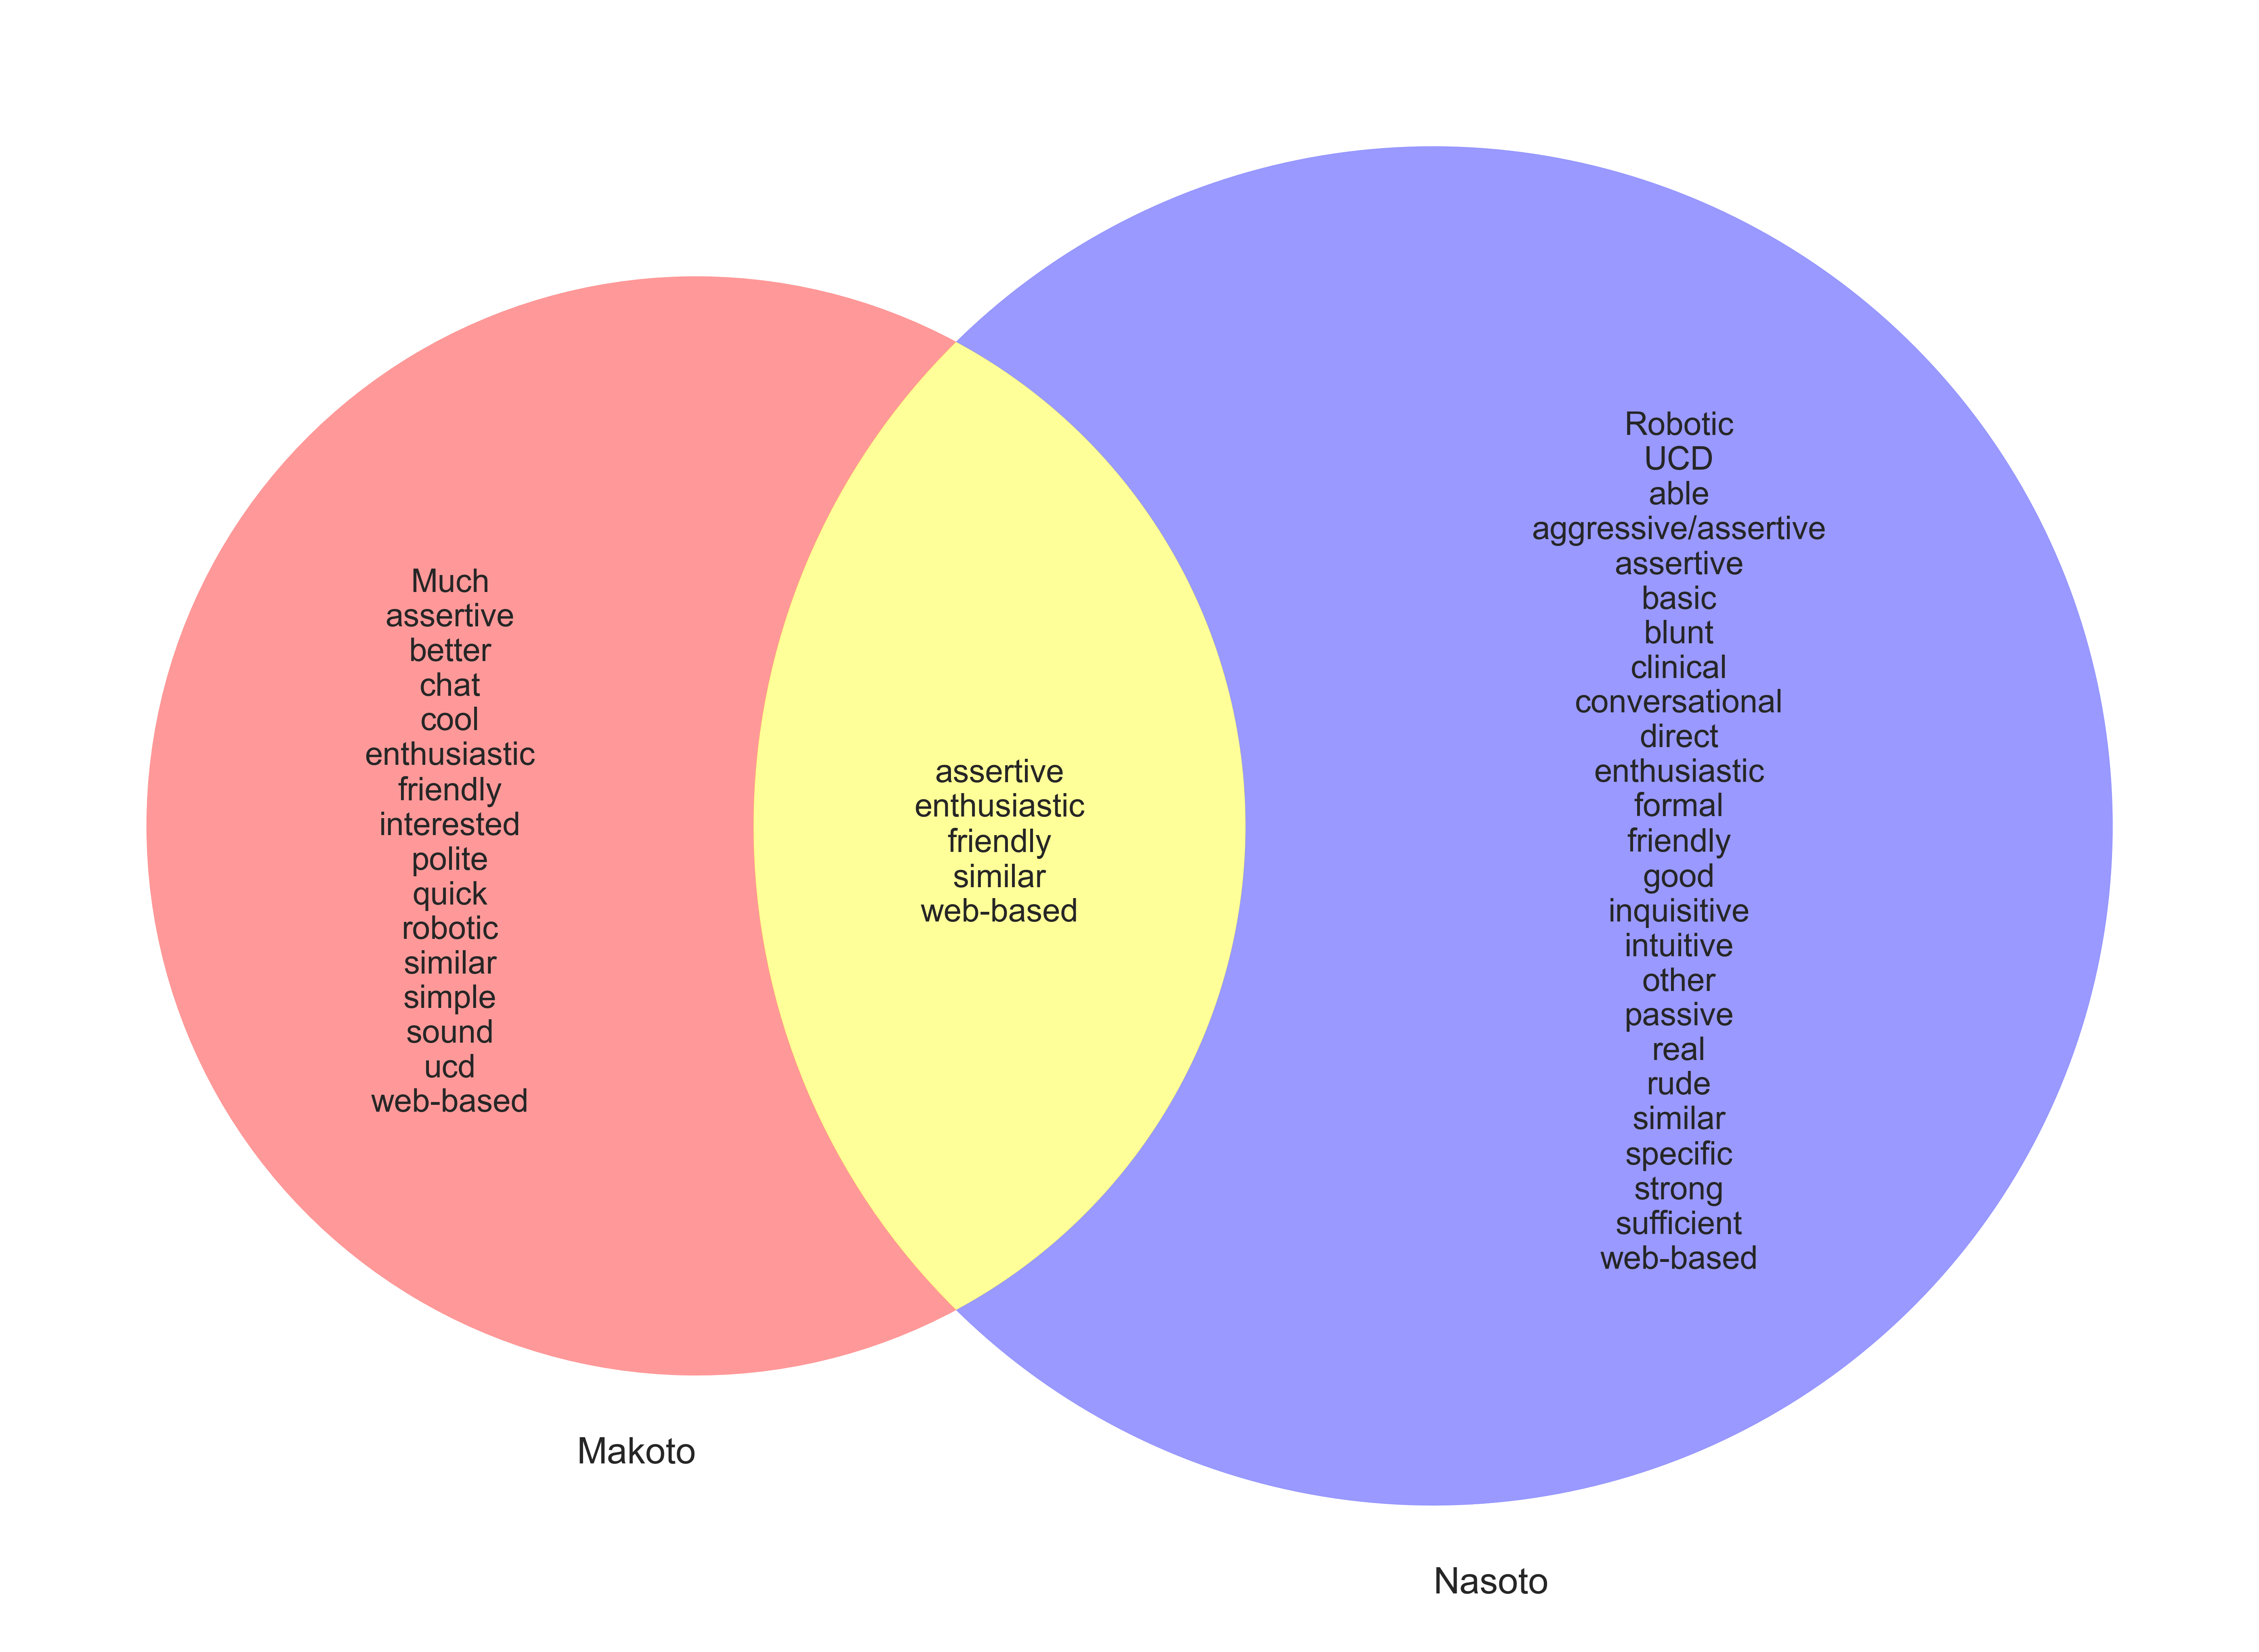

In [191]:
import math
from matplotlib import pyplot as plt
from matplotlib_venn import venn2, venn3
plt.figure(figsize=(100, 110))
s = [set(makoto_adj), set(nasoto_adj)]

# Create dictionary from sets
d = set2dict(s)

h = venn2(s, ('Makoto', 'Nasoto'))
for text in h.set_labels:
    text.set_fontsize(90)
h.get_patch_by_id('10').set_color('red')
h.get_patch_by_id('01').set_color('blue')
h.get_patch_by_id('11').set_color('yellow')
for k, v in d.items():
    l = h.get_label_by_id(k)
    if l:
        l.set_text('\n'.join(sorted(v)))
        l.set_fontsize(80)
plt.show()